In [1]:
import os
import random
from datetime import datetime, timedelta

import boto3
import numpy
import rasterio
import rioxarray
import xarray as xr
from matplotlib import pyplot as plt
import pystac
import pystac_client
import torch
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning import LightningModule, Trainer
import torchvision.transforms as T

In [2]:
def list_objects_recursive(client, bucket_name, prefix=''):
    """
    List all objects (file keys) in an S3 bucket recursively under a specified prefix.

    Args:
    - client (boto3.client): An initialized Boto3 S3 client.
    - bucket_name (str): The name of the S3 bucket.
    - prefix (str): The prefix (directory path) within the bucket to search for objects (optional).

    Returns:
    - list: A list of file keys (object keys) found under the specified prefix.
    """
    paginator = client.get_paginator('list_objects_v2')

    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    file_keys = []
    for page in page_iterator:
        if 'Contents' in page:
            file_keys.extend([obj['Key'] for obj in page['Contents']])

    return file_keys

In [3]:
image_array_values = []
label_array_values = []
flood_events = []
positions = []

def get_image_granules(bucket_name, prefix):
    """
    Get granules of N-dim datacube and label images from an S3 bucket.

    Args:
    - bucket_name (str): The name of the S3 bucket.
    - prefix (str): The prefix (directory path) in the S3 bucket.

    Returns:
    - tuple: None.
    """
    # Initialize Boto3 S3 client
    s3 = boto3.client('s3')

    # List objects in the specified prefix (directory) in the bucket
    files_in_s3 = list_objects_recursive(s3, bucket_name, prefix)

    # Filter S2 and S1 images
    #S2_labels = [i for i in files_in_s3_gt if '/s2/' in i and 'LabelWater.tif' in i]
    S1_labels = [i for i in files_in_s3 if 'LabelWater.tif' in i]
    datacube_images = [f"{i[:-15]}.tif" for i in S1_labels]
    
    for i in datacube_images[0:100]:
        position = '_'.join(i.split('/')[-1].split('_')[-3:-1])
        positions.append(position)
        flood_event = i.split('/')[-2]
        flood_events.append(flood_event)         
        # Load the image file from S3 directly into memory using rasterio
        obj = s3.get_object(Bucket=bucket_name, Key=i)
        with rasterio.io.MemoryFile(obj['Body'].read()) as memfile:
            with memfile.open() as dataset:
                data_array = rioxarray.open_rasterio(dataset)
                #print(data_array.values)
                pair = [i, data_array.values]
                image_array_values.append(pair)
    for i in S1_labels[0:100]:
        # Load the image file from S3 directly into memory using rasterio
        obj = s3.get_object(Bucket=bucket_name, Key=i)
        with rasterio.io.MemoryFile(obj['Body'].read()) as memfile:
            with memfile.open() as dataset:
                data_array = rioxarray.open_rasterio(dataset)
                #print(data_array.values)
                pair = [i, data_array.values]
                label_array_values.append(pair)

get_image_granules(bucket_name='clay-benchmark', prefix='c2smsfloods/datacube/chips_512/')

c2smsfloods/datacube/chips_512/0c7daa97-37f6-4862-867f-b3843f298d9e/S2A_L2A_20180505T070621_N0206_R106_T38NML_20180505T091900_09293-03569_S1B_IW_GRDH_1SDV_20180507T151605_20180507T151630_010817_013C63_rtc.tif
['c2smsfloods/datacube/chips_512/0c7daa97-37f6-4862-867f-b3843f298d9e/S2A_L2A_20180505T070621_N0206_R106_T38NML_20180505T091900_09293-03569_S1B_IW_GRDH_1SDV_20180507T151605_20180507T151630_010817_013C63_rtc_LabelWater.tif', 'c2smsfloods/datacube/chips_512/0c7daa97-37f6-4862-867f-b3843f298d9e/S2A_L2A_20180505T070621_N0206_R106_T38NNH_20180505T091900_01845-00514_S1B_IW_GRDH_1SDV_20180507T151511_20180507T151540_010817_013C63_rtc_LabelWater.tif']


In [4]:
import random
random.seed(9)  # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids_values = range(len(label_array_values))
val_chip_ids_values = random.sample(chip_ids_values, round(len(chip_ids_values) * 0.33))
train_chip_ids_values = [i for i in chip_ids_values if i not in val_chip_ids_values]
train_images_values = []
train_labels_values = []
for i,j,k in zip(image_array_values, label_array_values, range(len(image_array_values))):
    if k in train_chip_ids_values:
        train_images_values.append(i)
        train_labels_values.append(j)
val_images_values = []
val_labels_values = []
for i,j,k in zip(image_array_values, label_array_values, range(len(image_array_values))):
    if k in val_chip_ids_values:
        val_images_values.append(i)
        val_labels_values.append(j)
        
print(len(train_images_values), len(val_images_values), len(train_labels_values), len(val_labels_values))

67 33 67 33


In [8]:
def plot(merged):
    """
    Plot a tile in RGB and vh, and DEM
    """

    # data = merged.coarsen(x=100, y=100, boundary="trim").mean()
    data = merged

    fig, axs = plt.subplots(1, 3, figsize=(30, 30))


    rgb = (
        numpy.array(
            [
                data[2],
                data[1],
                data[0],
            ]
        ).clip(0, 3000)
        / 3000
    )
    axs[0].imshow(rgb.transpose(1, 2, 0))
    axs[0].set_title("Sentinel-2", fontsize=15)
    axs[1].imshow(numpy.log(data[11]))
    axs[1].set_title("Sentinel-1 VH", fontsize=15)
    axs[2].imshow(data[12])
    axs[2].set_title("DEM", fontsize=15)

    plt.show()

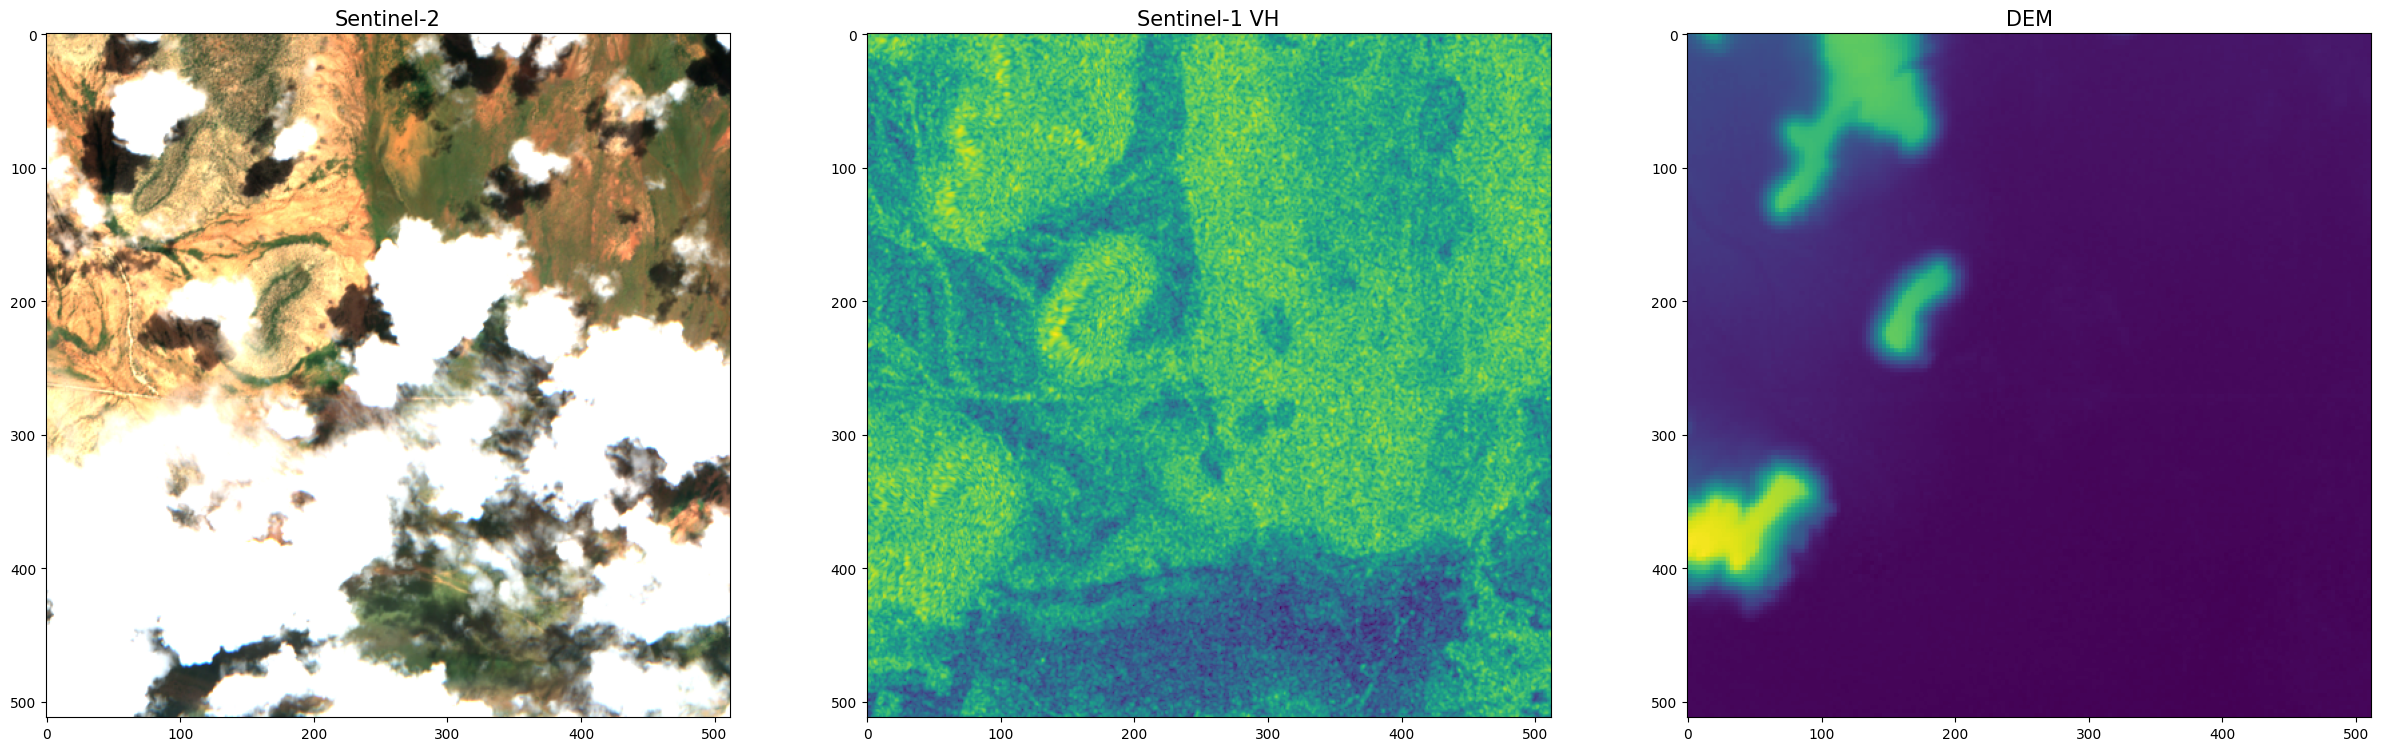

In [11]:
plot(image_array_values[0][1])

In [22]:
class DataModule_Floods(LightningModule):
    def __init__(self, train_images, val_images, train_labels, val_labels, batch_size=2, num_workers=4):
        super().__init__()
        self.train_images = train_images
        self.val_images = val_images
        self.train_labels = train_labels
        self.val_labels = val_labels
        self.batch_size = batch_size
        self.num_workers = num_workers 
        
        self.train_dataset = self.get_dataset(self.train_images, self.train_labels)
        self.val_dataset = self.get_dataset(self.val_images, self.val_labels)

    def get_dataset(self, images, labels):
        print(images[0][1].transpose(1,2,0).shape, labels[0][1].transpose(1,2,0).shape)
        features = [torch.from_numpy(numpy.array(item[1]).transpose(1,2,0)) for item in images]  # Convert NumPy array to PyTorch tensor
        targets = [torch.from_numpy(numpy.array(item[1]).transpose(1,2,0)) for item in labels] 
        print(len(features),len(targets))
        return features, targets

    def train_dataloader(self):
        # Return the training DataLoader
        #transform = transforms.Compose([transforms.ToTensor()])
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)
        return train_loader

    def val_dataloader(self):
        # Return the training DataLoader
        #transform = transforms.Compose([transforms.ToTensor()])
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)
        return val_loader
        
datamodule_floods = DataModule_Floods(train_images_values, val_images_values, train_labels_values, val_labels_values)
datamodule_floods.setup(stage='fit')



(512, 512, 13) (512, 512, 1)
67 67
(512, 512, 13) (512, 512, 1)
33 33


'\nclass SegModel(LightningModule):\n    def __init__(self, batch_size=1, num_workers=4):\n        super().__init__()\n        self.batch_size = batch_size\n        self.num_workers = num_workers\n\n        #self.model = YOLOX()  # Initialize YOLOX model\n    def forward(self, x):\n        return self.model(x)\n\n    def training_step(self, batch, batch_idx):\n        imgs, targets = batch\n        outputs = self.model(imgs)\n        loss = self.model.loss(outputs, targets)\n        self.log(\'train_loss\', loss)\n        print("loss: ", loss)\n        return loss\n\n    def validation_step(self, batch, batch_idx):\n        imgs, targets = batch\n        outputs = self.model(imgs)\n        loss = self.model.loss(outputs, targets)\n        self.log(\'val_loss\', loss)\n        return loss\n\n    def configure_optimizers(self):\n        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)\n        scheduler = {\n            \'scheduler\': torch.optim.lr_scheduler.StepLR(optimize

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        # Decoder
        x = self.decoder(x1)
        return x

class SegmentationModel(LightningModule):
    def __init__(self, model, datamodule):
        super().__init__()
        self.model = model
        self.datamodule = datamodule

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch  # x: input image, y: ground truth mask
        y_pred = self.model(x)
        loss = torch.nn.functional.cross_entropy(y_pred, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        print(len(batch)) #.shape)
        x, y = batch  # x: input image, y: ground truth mask
        y_pred = self.model(x)
        val_loss = torch.nn.functional.cross_entropy(y_pred, y)
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

model = UNet(13, 1) 
segmentation_model = SegmentationModel(model, datamodule_floods)

trainer = Trainer(max_epochs=10)  
trainer.fit(segmentation_model)
